In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/AutismDL/EEGdata'

In [ ]:
import numpy as np
from scipy.io import loadmat
import os

In [ ]:
# move events to first and channel to last
def moveaxis(X):
  X = np.moveaxis(X, 0, 2)
  X = np.moveaxis(X, 0, 1)
  X.shape
  # print(type(X))
  # print(type(y))
  # print(X.shape, y.shape)
  return X

# Reduce epochs by taking window from [0 ms, 600 ms]
def reduce_epochs(X):
  new_window_start = 200
  new_window_end = 600

  # Original time window in milliseconds
  original_window_start = -200
  original_window_end = 1200

  # Calculate the indices corresponding to the new time window
  new_window_start_index = int((new_window_start - original_window_start) / 1000 * 250)
  new_window_end_index = int((new_window_end - original_window_start) / 1000 * 250)

  # Slice the data to get the new window
  X_new_window = X[:, new_window_start_index:new_window_end_index, :]
  return X_new_window


# take all sessions input
def takeInput():
  # List all session folders (S01 to S07)
  session_folders = [f"S{i:02d}" for i in range(1, 8)]
  sbj_folders = [f"SBJ{i:02d}" for i in range(1, 9)]

  # Initialize an empty list to store data arrays
  train_data_arrays = []
  test_data_arrays = []
  train_target_arrays = []
  test_target_arrays = []

  # loop through each subject
  for sbj_folder in sbj_folders:

    sbj_path = os.path.join(file_path, sbj_folder)

    # Loop through each session folder
    for session_folder in session_folders:
        # Construct the path to the Train folder for the current session
        train_folder_path = os.path.join(sbj_path, session_folder, 'Train')
        test_folder_path = os.path.join(sbj_path, session_folder, 'Test')

        # Load trainData.mat from the Train folder
        train_data_path = os.path.join(train_folder_path, 'trainData.mat')
        test_data_path = os.path.join(test_folder_path, 'testData.mat')
        train_data = loadmat(train_data_path)['trainData']
        test_data = loadmat(test_data_path)['testData']

        train_target_file_path = os.path.join(train_folder_path, 'trainTargets.txt')
        test_target_file_path = os.path.join(test_folder_path, 'testTargets.txt')

        with open(train_target_file_path, 'r') as file:
          target_data = np.loadtxt(file)
          # Append the target array to the list
          train_target_arrays.append(target_data)

        with open(test_target_file_path, 'r') as file:
          target_data = np.loadtxt(file)
          # Append the target array to the list
          test_target_arrays.append(target_data)

        # Append the data array to the list
        train_data_arrays.append(train_data)
        test_data_arrays.append(test_data)

  # Concatenate along the events axis (axis=2)
  train_concatenated_features = np.concatenate(train_data_arrays, axis=2)
  test_concatenated_features = np.concatenate(test_data_arrays, axis=2)

  train_concatenated_targets = np.concatenate(train_target_arrays)
  train_concatenated_targets = train_concatenated_targets.astype(int)

  test_concatenated_targets = np.concatenate(test_target_arrays)
  test_concatenated_targets = test_concatenated_targets.astype(int)

  # The shape of concatenated_data should be (8, 350, 1600)
  return train_concatenated_features, test_concatenated_features, train_concatenated_targets, test_concatenated_targets

In [ ]:
X, X_test, y, Y_test = takeInput()
print(X.shape, X_test.shape, y.shape, Y_test.shape)

(8, 350, 89600) (8, 350, 157600) (89600,) (157600,)


In [ ]:
# import copy

# X_copy = copy.deepcopy(X)
# X_test_copy = copy.deepcopy(X_test)
# y_copy = copy.deepcopy(y)
# Y_test_copy = copy.deepcopy(Y_test)

In [ ]:
unique_classes, class_counts = np.unique(y, return_counts=True)

# Display the counts for each unique class
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

Class 0: 78400 samples
Class 1: 11200 samples


In [ ]:
X = moveaxis(X)
X_test = moveaxis(X_test)
print(X.shape, X_test.shape)

(89600, 350, 8) (157600, 350, 8)


In [ ]:
X = reduce_epochs(X)
X_test = reduce_epochs(X_test)
print(X.shape, X_test.shape)

(89600, 100, 8) (157600, 100, 8)


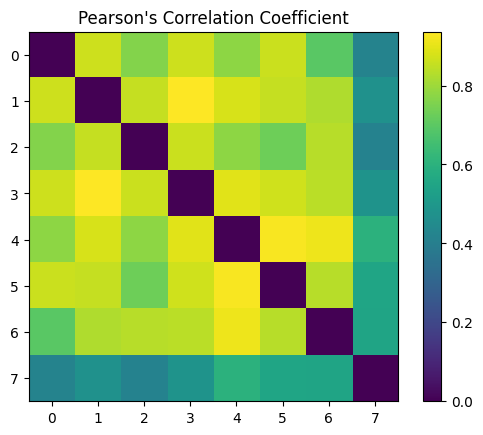

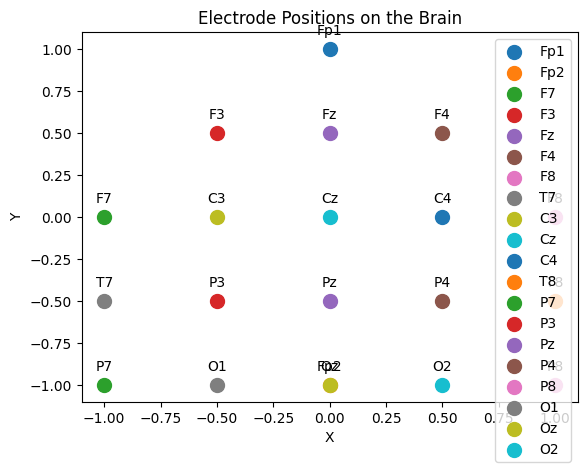

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming you have data X with shape (num_samples, num_epochs, num_channels)
# Replace this with your actual data
# 10-10 system electrode positions (replace with actual coordinates)
electrode_positions = {
    'Fp1': (0, 1), 'Fp2': (0, -1),
    'F7': (-1, 0), 'F3': (-0.5, 0.5), 'Fz': (0, 0.5), 'F4': (0.5, 0.5), 'F8': (1, 0),
    'T7': (-1, -0.5), 'C3': (-0.5, 0), 'Cz': (0, 0), 'C4': (0.5, 0), 'T8': (1, -0.5),
    'P7': (-1, -1), 'P3': (-0.5, -0.5), 'Pz': (0, -0.5), 'P4': (0.5, -0.5), 'P8': (1, -1),
    'O1': (-0.5, -1), 'Oz': (0, -1), 'O2': (0.5, -1)
}

# Calculate correlation coefficients
num_samples, num_epochs, num_channels = X.shape
correlation_matrix = np.zeros((num_channels, num_channels))
for i in range(num_channels):
    for j in range(num_channels):
        if i != j:
            data1 = X[:, :, i].flatten()
            data2 = X[:, :, j].flatten()
            correlation, _ = pearsonr(data1, data2)
            correlation_matrix[i, j] = correlation

# Plot the correlation matrix
plt.imshow(correlation_matrix, cmap='viridis', interpolation='none')
plt.colorbar()
plt.title("Pearson's Correlation Coefficient")
plt.show()

# Plot the electrode positions on the brain
fig, ax = plt.subplots()
for electrode, pos in electrode_positions.items():
    ax.scatter(pos[0], pos[1], label=electrode, s=100)
    ax.annotate(electrode, (pos[0], pos[1]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title("Electrode Positions on the Brain")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


### Random CNN model

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, ConvLSTM2D, BatchNormalization, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.optimizers import Adam

# Assuming you have your data in 'X' and labels in 'y'
# X.shape should be (1600, 350, 8) for 1600 events, 350 epochs, and 8 channels

# Define the CNN model
model = Sequential()
opt = Adam(learning_rate = 0.001)

# Add 1D convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100, 8)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output to feed into dense layers
model.add(Flatten())

# Add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.05))
  # Optional dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, y, epochs=9, batch_size=1000, validation_split=0.2)
accuracy = model.evaluate(X_test, Y_test)[1]
print(f"Test Accuracy: {accuracy}")

Epoch 1/9
72/72 [==============================] - 34s 433ms/step - loss: 0.5537 - accuracy: 0.8505 - val_loss: 0.4050 - val_accuracy: 0.8750
Epoch 2/9
72/72 [==============================] - 24s 338ms/step - loss: 0.3660 - accuracy: 0.8752 - val_loss: 0.3563 - val_accuracy: 0.8755
Epoch 3/9
72/72 [==============================] - 30s 421ms/step - loss: 0.3478 - accuracy: 0.8761 - val_loss: 0.3491 - val_accuracy: 0.8788
Epoch 4/9
72/72 [==============================] - 27s 383ms/step - loss: 0.3402 - accuracy: 0.8769 - val_loss: 0.3400 - val_accuracy: 0.8800
Epoch 5/9
72/72 [==============================] - 29s 401ms/step - loss: 0.3307 - accuracy: 0.8785 - val_loss: 0.3291 - val_accuracy: 0.8832
Epoch 6/9
72/72 [==============================] - 26s 368ms/step - loss: 0.3225 - accuracy: 0.8812 - val_loss: 0.3219 - val_accuracy: 0.8877
Epoch 7/9
72/72 [==============================] - 27s 370ms/step - loss: 0.3147 - accuracy: 0.8825 - val_loss: 0.3168 - val_accuracy: 0.8860
Epoch 

### 3 layers

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, ConvLSTM2D, BatchNormalization, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.optimizers import Adam

# Assuming you have your data in 'X' and labels in 'y'
# X.shape should be (1600, 350, 8) for 1600 events, 350 epochs, and 8 channels

# Define the CNN model
model = Sequential()
opt = Adam(learning_rate = 0.001)

# Add 1D convolutional layers
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(100, 8)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output to feed into dense layers
model.add(Flatten())

# Add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.05))
  # Optional dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, y, epochs=9, batch_size=1000, validation_split=0.2)
accuracy = model.evaluate(X_test, Y_test)[1]
print(f"Test Accuracy: {accuracy}")

Epoch 1/9
72/72 [==============================] - 12s 135ms/step - loss: 0.5126 - accuracy: 0.8461 - val_loss: 0.4069 - val_accuracy: 0.8750
Epoch 2/9
72/72 [==============================] - 8s 105ms/step - loss: 0.3902 - accuracy: 0.8749 - val_loss: 0.3969 - val_accuracy: 0.8750
Epoch 3/9
72/72 [==============================] - 10s 145ms/step - loss: 0.3786 - accuracy: 0.8750 - val_loss: 0.3775 - val_accuracy: 0.8750
Epoch 4/9
72/72 [==============================] - 10s 140ms/step - loss: 0.3664 - accuracy: 0.8750 - val_loss: 0.3543 - val_accuracy: 0.8751
Epoch 5/9
72/72 [==============================] - 7s 95ms/step - loss: 0.3547 - accuracy: 0.8749 - val_loss: 0.3465 - val_accuracy: 0.8751
Epoch 6/9
72/72 [==============================] - 10s 146ms/step - loss: 0.3461 - accuracy: 0.8750 - val_loss: 0.3240 - val_accuracy: 0.8757
Epoch 7/9
72/72 [==============================] - 7s 95ms/step - loss: 0.3396 - accuracy: 0.8756 - val_loss: 0.3243 - val_accuracy: 0.8761
Epoch 8/9
7

### With early stopping

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, ConvLSTM2D, BatchNormalization, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Assuming you have your data in 'X' and labels in 'y'
# X.shape should be (1600, 350, 8) for 1600 events, 350 epochs, and 8 channels

# Define the CNN model
model = Sequential()
opt = Adam(learning_rate=0.001)

# Add 1D convolutional layers
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(100, 8)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output to feed into dense layers
model.add(Flatten())

# Add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.05))
# Optional dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y, epochs=30, batch_size=1000, validation_split=0.2, callbacks=[early_stopping])
accuracy = model.evaluate(X_test, Y_test)[1]
print(f"Test Accuracy: {accuracy}")


Epoch 1/30
72/72 [==============================] - 122s 2s/step - loss: 0.3870 - accuracy: 0.8726 - val_loss: 0.3728 - val_accuracy: 0.8753
Epoch 2/30
72/72 [==============================] - 117s 2s/step - loss: 0.3469 - accuracy: 0.8762 - val_loss: 0.3274 - val_accuracy: 0.8828
Epoch 3/30
72/72 [==============================] - 110s 2s/step - loss: 0.3325 - accuracy: 0.8788 - val_loss: 0.3108 - val_accuracy: 0.8902
Epoch 4/30
72/72 [==============================] - 113s 2s/step - loss: 0.3175 - accuracy: 0.8820 - val_loss: 0.3121 - val_accuracy: 0.8871
Epoch 5/30
72/72 [==============================] - 113s 2s/step - loss: 0.3082 - accuracy: 0.8845 - val_loss: 0.2996 - val_accuracy: 0.8951
Epoch 6/30
72/72 [==============================] - 100s 1s/step - loss: 0.2988 - accuracy: 0.8867 - val_loss: 0.2940 - val_accuracy: 0.8972
Epoch 7/30
72/72 [==============================] - 107s 1s/step - loss: 0.2898 - accuracy: 0.8896 - val_loss: 0.3111 - val_accuracy: 0.8879
Epoch 8/30
72

### With 5-Fold Cross Validation

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Assuming X and y are your data and labels
# Set the number of folds (k)
num_folds = 5

# Initialize StratifiedKFold
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store results
accuracies = []

# Iterate through each fold
for fold_index, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"Training on Fold {fold_index + 1}")

    # Split the data into training and validation sets
    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    # Create a new instance of the model
    model = Sequential()
    opt = Adam(learning_rate=0.001)

    # Add 1D convolutional layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100, 8)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Flatten the output to feed into dense layers
    model.add(Flatten())

    # Add dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))  # Optional dropout for regularization
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    # Compile the model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on the current fold
    history = model.fit(X_train, y_train, epochs=9, batch_size=1000, validation_data=(X_val, y_val))

    # Evaluate the model on the test set for this fold
    accuracy = model.evaluate(X_test, Y_test)[1]
    accuracies.append(accuracy)

    print(f"Test Accuracy for Fold {fold_index + 1}: {accuracy}")

# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f"\nAverage Test Accuracy: {average_accuracy}")


Training on Fold 1
Epoch 1/9
72/72 [==============================] - 18s 236ms/step - loss: 0.3954 - accuracy: 0.8729 - val_loss: 0.3494 - val_accuracy: 0.8751
Epoch 2/9
72/72 [==============================] - 16s 223ms/step - loss: 0.3474 - accuracy: 0.8778 - val_loss: 0.3335 - val_accuracy: 0.8796
Epoch 3/9
72/72 [==============================] - 16s 216ms/step - loss: 0.3258 - accuracy: 0.8818 - val_loss: 0.3213 - val_accuracy: 0.8824
Epoch 4/9
72/72 [==============================] - 16s 218ms/step - loss: 0.3108 - accuracy: 0.8863 - val_loss: 0.3134 - val_accuracy: 0.8850
Epoch 5/9
72/72 [==============================] - 15s 215ms/step - loss: 0.2967 - accuracy: 0.8888 - val_loss: 0.3095 - val_accuracy: 0.8868
Epoch 6/9
72/72 [==============================] - 15s 215ms/step - loss: 0.2845 - accuracy: 0.8925 - val_loss: 0.3111 - val_accuracy: 0.8872
Epoch 7/9
72/72 [==============================] - 15s 215ms/step - loss: 0.2754 - accuracy: 0.8945 - val_loss: 0.3106 - val_accu

### Santamaria model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, ConvLSTM2D, BatchNormalization, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, Callback, ModelCheckpoint

def cnn_lstm():

    # Parameters
    n_filt_conv1 = 32
    ker_size_conv1 = 4
    stride_conv1 = 4
    drop_conv1 = 0.1

    n_neurons_lstm1 = 16
    drop_lstm1 = 0.1
    recurrent_drop_lstm1 = 0.0

    n_neurons_lstm2 = 8
    drop_lstm2 = 0.1
    recurrent_drop_lstm2 = 0.0

    # Keras model
    model = Sequential()
    # Convolutional Layer
    model.add(BatchNormalization())
    model.add(Conv1D(filters=n_filt_conv1,
                      kernel_size=ker_size_conv1,
                      strides=stride_conv1,
                      activation='relu',
                      kernel_initializer='he_normal',
                      input_shape=(100,8)))
    model.add(Dropout(drop_conv1))
    # LSTM layer
    model.add(BatchNormalization())
    model.add(LSTM(n_neurons_lstm1,
                   return_sequences=True,
                   dropout=drop_lstm1,
                   recurrent_dropout=recurrent_drop_lstm1))
    # LSTM layer
    model.add(BatchNormalization())
    model.add(LSTM(n_neurons_lstm2,
                   return_sequences=False,
                   dropout=drop_lstm2,
                   recurrent_dropout=recurrent_drop_lstm2))
    #Block3
    model.add(Dense(1, activation='sigmoid'))
    return model

def cnn_blstm():

    # Parameters
    n_filt_conv1 = 32
    ker_size_conv1 = 4
    stride_conv1 = 4
    drop_conv1 = 0.1

    n_neurons_lstm1 = 16
    drop_lstm1 = 0.1
    recurrent_drop_lstm1 = 0.0

    n_neurons_lstm2 = 8
    drop_lstm2 = 0.1
    recurrent_drop_lstm2 = 0.0

    # Keras model
    model = Sequential()
    # Convolutional Layer
    model.add(BatchNormalization())
    model.add(Conv1D(filters=n_filt_conv1,
                      kernel_size=ker_size_conv1,
                      strides=stride_conv1,
                      activation='relu',
                      kernel_initializer='he_normal',
                      input_shape=(100,8)))
    model.add(Dropout(drop_conv1))
    # LSTM layer
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(n_neurons_lstm1,
                                 return_sequences=True,
                                 dropout=drop_lstm1,
                                 recurrent_dropout=recurrent_drop_lstm1)))
    # LSTM layer
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(n_neurons_lstm2,
                                 return_sequences=False,
                                 dropout=drop_lstm2,
                                 recurrent_dropout=recurrent_drop_lstm2)))
    #Block3
    model.add(Dense(1, activation='sigmoid'))
    return model

model2 = cnn_blstm()
# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X, y, epochs=10, batch_size=1000, validation_split=0.2)
accuracy2 = model.evaluate(X_test, Y_test)[1]
print(f"Test Accuracy: {accuracy2}")

Epoch 1/10
72/72 [==============================] - 41s 283ms/step - loss: 0.4445 - accuracy: 0.8365 - val_loss: 0.4338 - val_accuracy: 0.8737
Epoch 2/10
72/72 [==============================] - 20s 274ms/step - loss: 0.3671 - accuracy: 0.8750 - val_loss: 0.3819 - val_accuracy: 0.8750
Epoch 3/10
72/72 [==============================] - 19s 260ms/step - loss: 0.3612 - accuracy: 0.8749 - val_loss: 0.3613 - val_accuracy: 0.8751
Epoch 4/10
72/72 [==============================] - 20s 276ms/step - loss: 0.3575 - accuracy: 0.8749 - val_loss: 0.3524 - val_accuracy: 0.8750
Epoch 5/10
72/72 [==============================] - 19s 272ms/step - loss: 0.3527 - accuracy: 0.8750 - val_loss: 0.3444 - val_accuracy: 0.8752
Epoch 6/10
72/72 [==============================] - 19s 262ms/step - loss: 0.3479 - accuracy: 0.8750 - val_loss: 0.3317 - val_accuracy: 0.8761
Epoch 7/10
72/72 [==============================] - 18s 253ms/step - loss: 0.3424 - accuracy: 0.8757 - val_loss: 0.3196 - val_accuracy: 0.8790

4925/4925 [==============================] - 18s 4ms/step


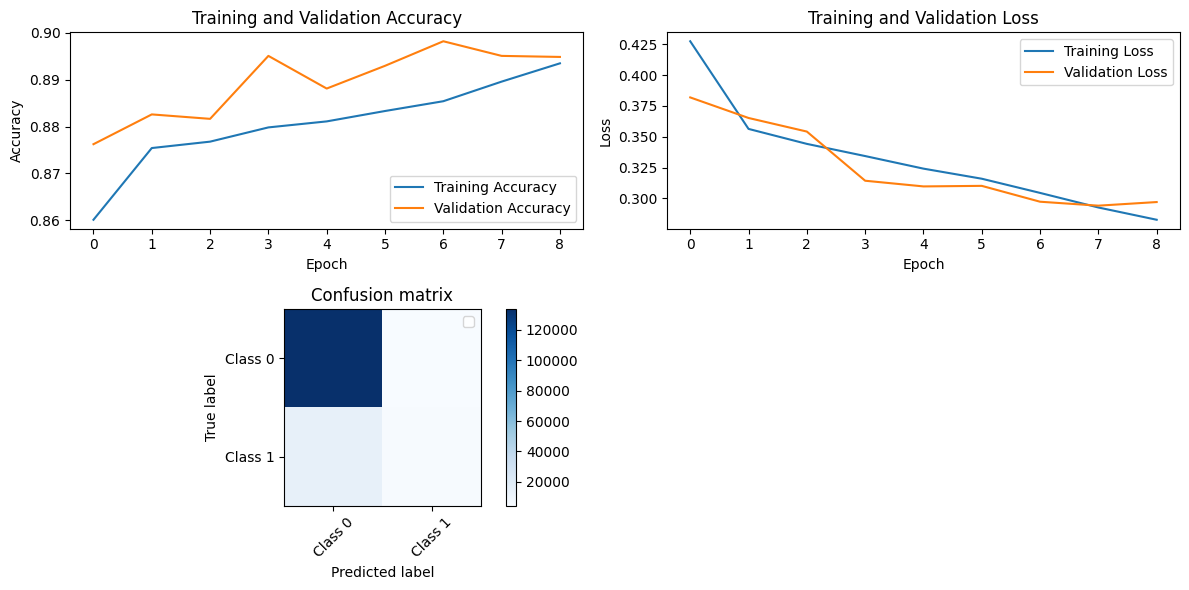

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot confusion matrix
plt.subplot(2, 2, 3)
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)
cm = confusion_matrix(Y_test, y_pred_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
classes = ['Class 0', 'Class 1']  # Replace with your actual class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 312ms/step


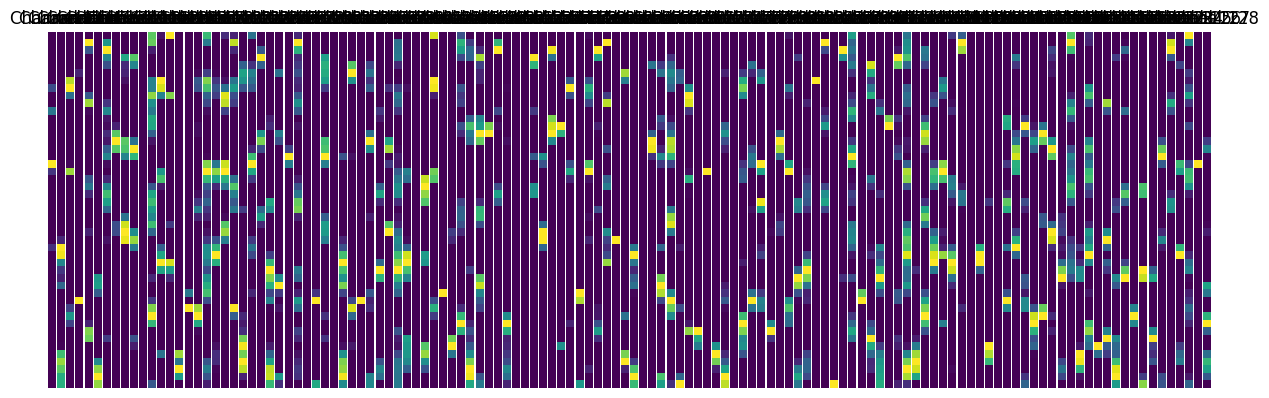

In [ ]:
from keras.models import Model

# Choose an intermediate layer index
layer_index = 2

# Create a submodel from the original model to extract feature maps
feature_map_model = Model(inputs=model.inputs, outputs=model.layers[layer_index].output)

# Choose a sample from the dataset for visualization
sample_index = 0
sample = X_test[sample_index].reshape(1, 100, 8)

# Get feature maps
feature_maps = feature_map_model.predict(sample)

# Plot feature maps
plt.figure(figsize=(15, 5))
for i in range(feature_maps.shape[2]):
    plt.subplot(1, feature_maps.shape[2], i + 1)
    plt.imshow(feature_maps[0, :, i].reshape((feature_maps.shape[1], 1)), cmap='viridis')
    plt.title(f'Channel {i+1}')
    plt.axis('off')
plt.show()


4925/4925 [==============================] - 31s 6ms/step


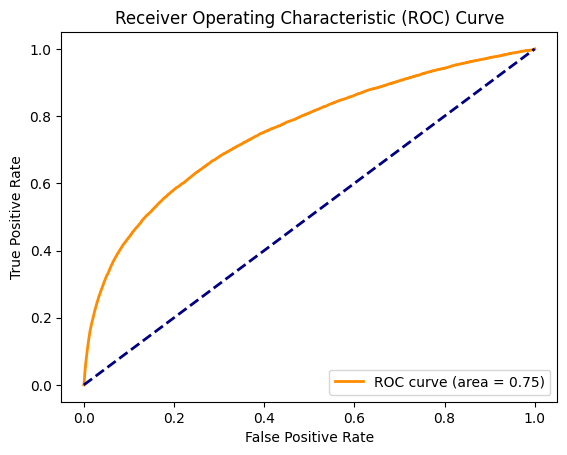

In [ ]:
y_pred_probs = model.predict(X_test)

# Plot ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()